## Import Library

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, classification_report, 
                            confusion_matrix, roc_curve, roc_auc_score)
from sklearn.feature_selection import VarianceThreshold


In [70]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "data.csv"

df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "uciml/breast-cancer-wisconsin-data",
  file_path,
)

print("First 5 records:\n", df.head())

First 5 records:
          id diagnosis  ...  fractal_dimension_worst  Unnamed: 32
0    842302         M  ...                  0.11890          NaN
1    842517         M  ...                  0.08902          NaN
2  84300903         M  ...                  0.08758          NaN
3  84348301         M  ...                  0.17300          NaN
4  84358402         M  ...                  0.07678          NaN

[5 rows x 33 columns]


## Preprocess Data

In [71]:
print("Dataset shape:", df.shape)
print("\nColumn names:", df.columns.tolist())

print("\nMissing values:", df.isnull().sum().sum())

if 'diagnosis' in df.columns:
    print("\nDiagnosis distribution:")
    print(df['diagnosis'].value_counts())
    print(df['diagnosis'].value_counts(normalize=True).round(3))

Dataset shape: (569, 33)

Column names: ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32']

Missing values: 569

Diagnosis distribution:
diagnosis
B    357
M    212
Name: count, dtype: int64
diagnosis
B    0.627
M    0.373
Name: proportion, dtype: float64


In [72]:
missing_cols = df.columns[df.isnull().any()].tolist()
print("Columns with missing values:", missing_cols)

for col in missing_cols:
    print(f"{col}: {df[col].isna().sum()} missing values")

if 'Unnamed: 32' in df.columns:
    df = df.drop('Unnamed: 32', axis=1)

print("New dataset shape:", df.shape)

print("Missing values remaining:", df.isnull().sum().sum())

Columns with missing values: ['Unnamed: 32']
Unnamed: 32: 569 missing values
New dataset shape: (569, 32)
Missing values remaining: 0


In [73]:
if 'id' in df.columns:
    df = df.drop('id', axis=1)
elif 'ID' in df.columns:
    df = df.drop('ID', axis=1)

if 'diagnosis' in df.columns:
    df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

selector = VarianceThreshold(threshold=1e-8)
X_filtered = selector.fit_transform(X)

n_removed = X.shape[1] - X_filtered.shape[1]
if n_removed > 0:
    print(f"Removed {n_removed} constant or near-constant features")
    
    kept_features = X.columns[selector.get_support()].tolist()
    
    X = X[kept_features]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Testing set shape: {X_test_scaled.shape}")

Training set shape: (455, 30)
Testing set shape: (114, 30)


## Data Visualization

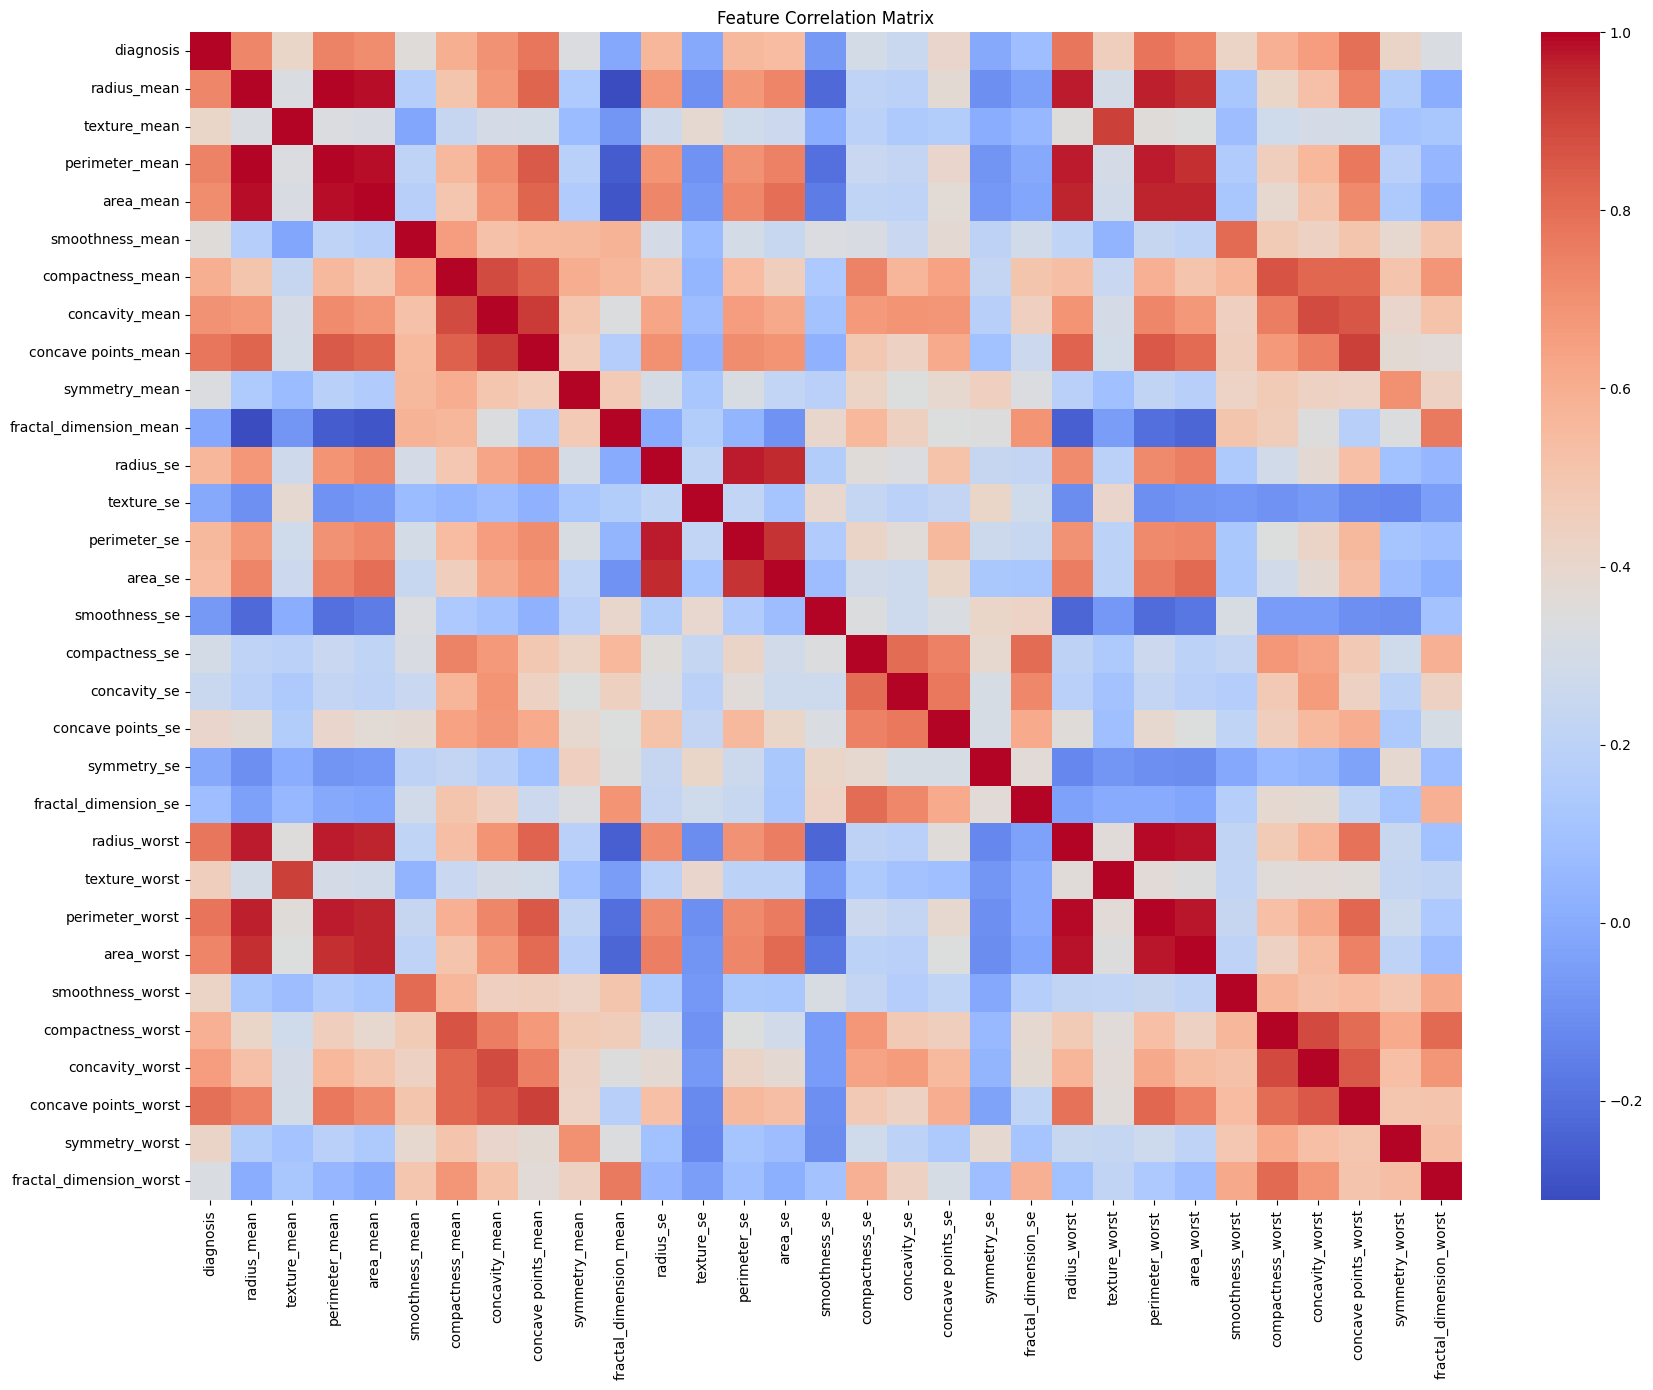

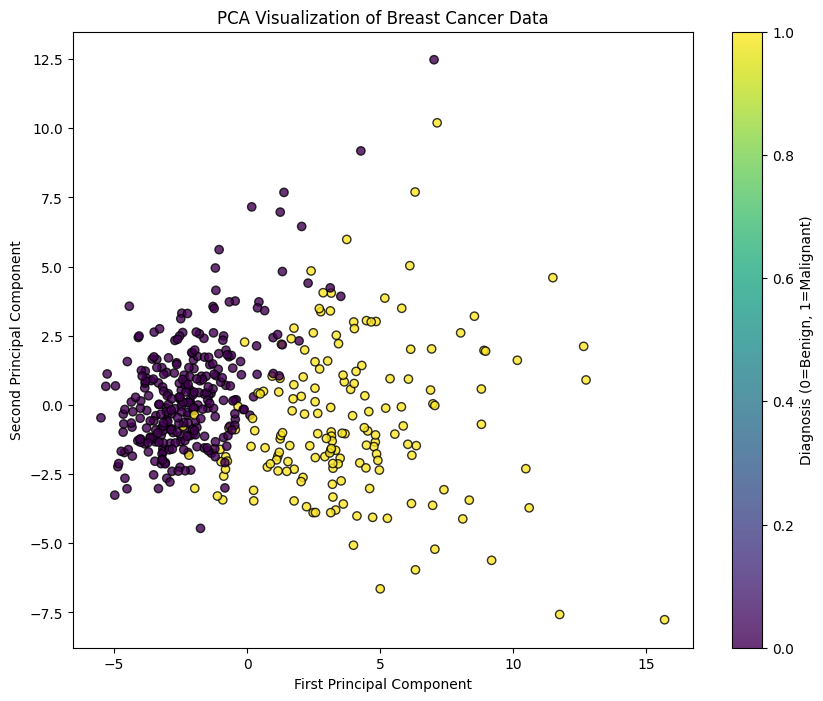

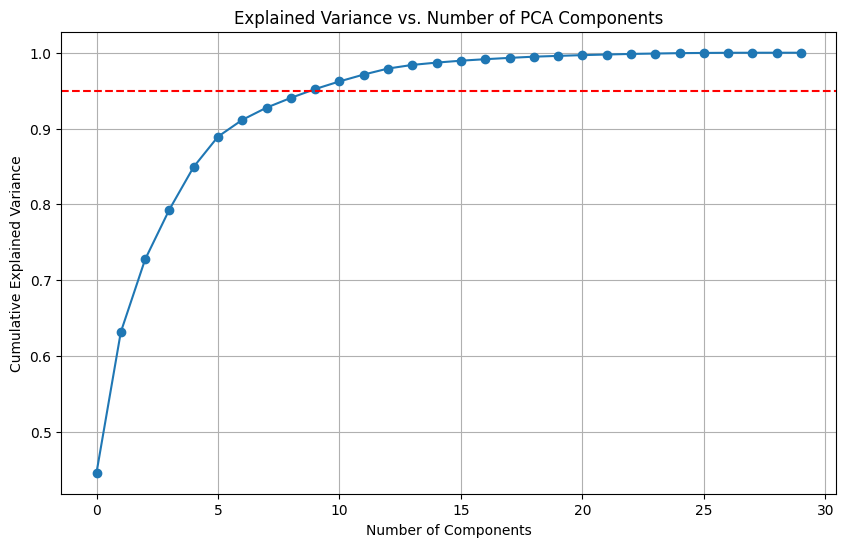

In [74]:
plt.figure(figsize=(18, 14))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis', 
            alpha=0.8, edgecolors='k')
plt.title('PCA Visualization of Breast Cancer Data')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(label='Diagnosis (0=Benign, 1=Malignant)')
plt.show()

pca_full = PCA()
pca_full.fit(X_train_scaled)

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.grid(True)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of PCA Components')
plt.show()

# Logistic Regression

## Baseline


==== Experiment 1: Baseline Model ====
Accuracy: 0.9649
ROC AUC: 0.9960

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        72
           1       0.97      0.93      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



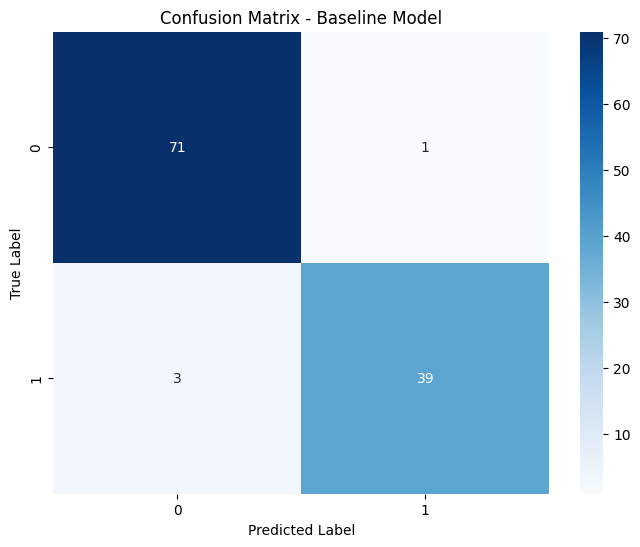

In [75]:
print("\n==== Experiment 1: Baseline Model ====")
baseline_model = LogisticRegression(random_state=42, max_iter=1000)
baseline_model.fit(X_train_scaled, y_train)

y_pred_baseline = baseline_model.predict(X_test_scaled)
y_prob_baseline = baseline_model.predict_proba(X_test_scaled)[:, 1]

baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
baseline_auc = roc_auc_score(y_test, y_prob_baseline)

print(f"Accuracy: {baseline_accuracy:.4f}")
print(f"ROC AUC: {baseline_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_baseline)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Baseline Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Dimensionality Reduction with PCA


==== Experiment 2: PCA Model ====
Original features: 30
PCA features (95% variance): 10
Accuracy: 0.9737
ROC AUC: 0.9970

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



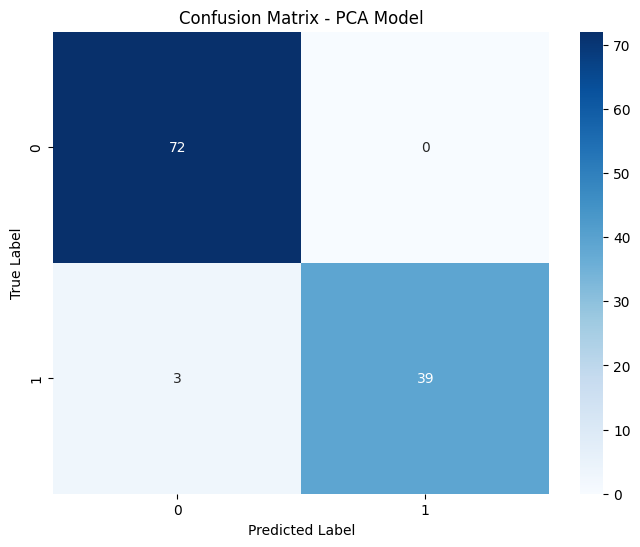

In [76]:
print("\n==== Experiment 2: PCA Model ====")

pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Original features: {X_train_scaled.shape[1]}")
print(f"PCA features (95% variance): {X_train_pca.shape[1]}")

pca_model = LogisticRegression(random_state=42, max_iter=1000)
pca_model.fit(X_train_pca, y_train)

y_pred_pca = pca_model.predict(X_test_pca)
y_prob_pca = pca_model.predict_proba(X_test_pca)[:, 1]

pca_accuracy = accuracy_score(y_test, y_pred_pca)
pca_auc = roc_auc_score(y_test, y_prob_pca)

print(f"Accuracy: {pca_accuracy:.4f}")
print(f"ROC AUC: {pca_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_pca))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_pca)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - PCA Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Dimensionality Reduction and Regularization


==== Experiment 3: PCA + Regularization Model ====
Best regularization parameter (C): 0.1
Accuracy: 0.9825
ROC AUC: 0.9980

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        72
           1       1.00      0.95      0.98        42

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



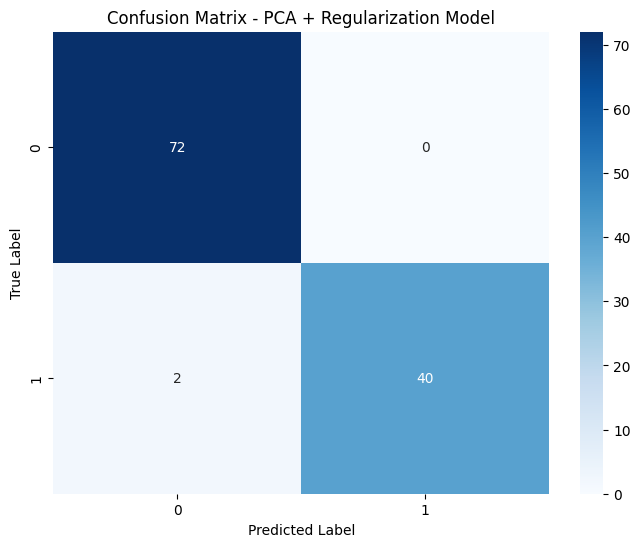

In [77]:
print("\n==== Experiment 3: PCA + Regularization Model ====")

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(
    LogisticRegression(penalty='l2', random_state=42, max_iter=1000),
    param_grid,
    cv=5,
    scoring='roc_auc'
)
grid_search.fit(X_train_pca, y_train)

best_C = grid_search.best_params_['C']
print(f"Best regularization parameter (C): {best_C}")

pca_reg_model = LogisticRegression(C=best_C, penalty='l2', random_state=42, max_iter=1000)
pca_reg_model.fit(X_train_pca, y_train)

y_pred_pca_reg = pca_reg_model.predict(X_test_pca)
y_prob_pca_reg = pca_reg_model.predict_proba(X_test_pca)[:, 1]

pca_reg_accuracy = accuracy_score(y_test, y_pred_pca_reg)
pca_reg_auc = roc_auc_score(y_test, y_prob_pca_reg)

print(f"Accuracy: {pca_reg_accuracy:.4f}")
print(f"ROC AUC: {pca_reg_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_pca_reg))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_pca_reg)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - PCA + Regularization Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Compare All Models


==== Model Comparison ====
                     Model  Accuracy   ROC AUC  Features
0              Baseline LR  0.964912  0.996032        30
1                   PCA LR  0.973684  0.997024        10
2  PCA + Regularization LR  0.982456  0.998016        10


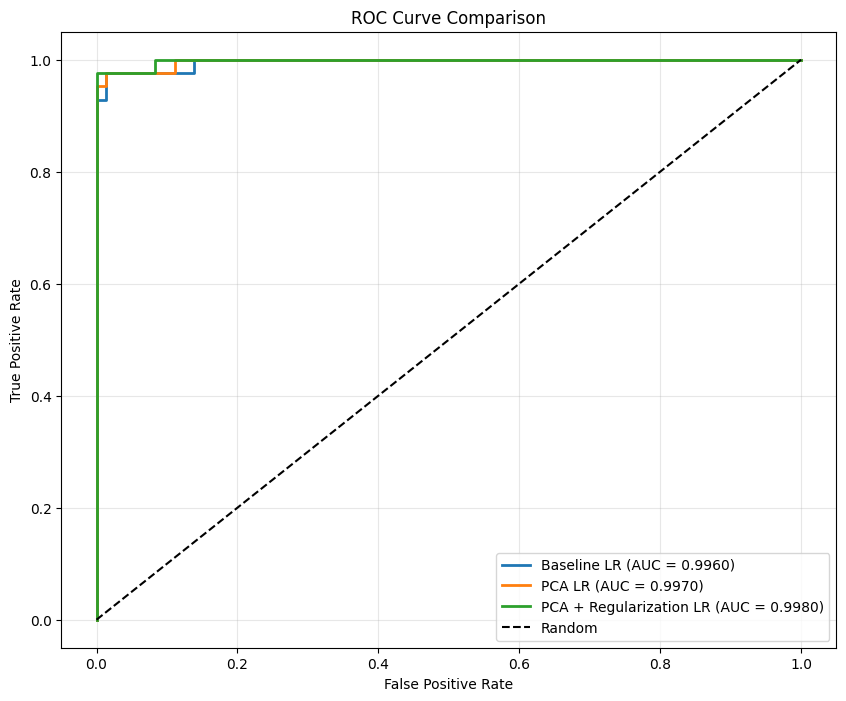

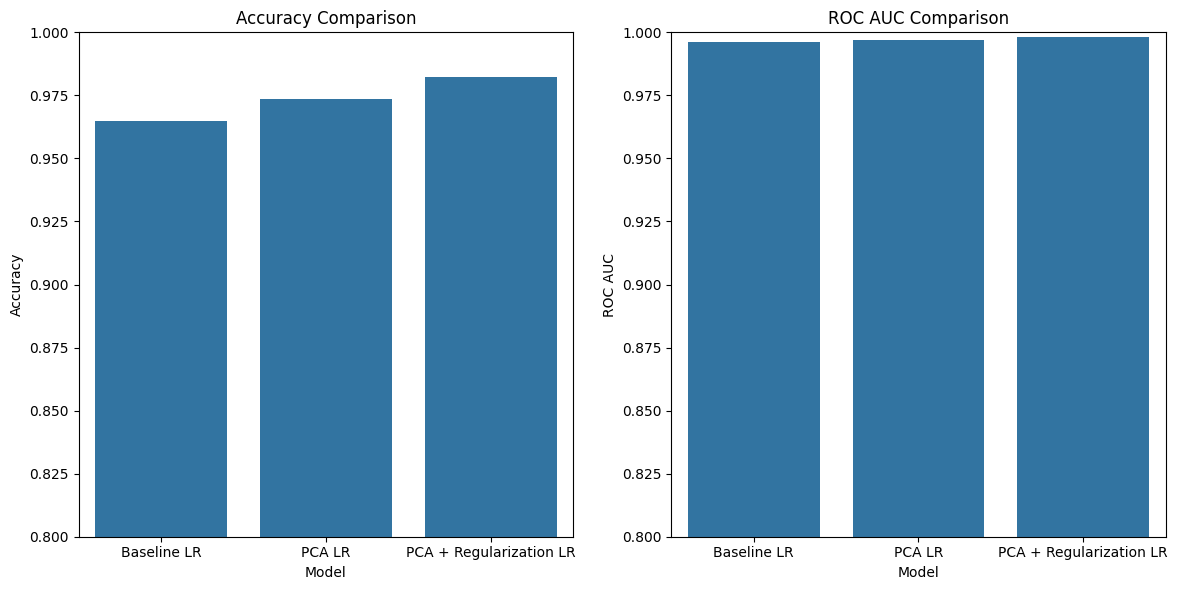

In [78]:
results = pd.DataFrame({
    'Model': ['Baseline LR', 'PCA LR', 'PCA + Regularization LR'],
    'Accuracy': [baseline_accuracy, pca_accuracy, pca_reg_accuracy],
    'ROC AUC': [baseline_auc, pca_auc, pca_reg_auc],
    'Features': [X_train_scaled.shape[1], X_train_pca.shape[1], X_train_pca.shape[1]]
})

print("\n==== Model Comparison ====")
print(results)

plt.figure(figsize=(10, 8))

fpr_base, tpr_base, _ = roc_curve(y_test, y_prob_baseline)
plt.plot(fpr_base, tpr_base, 
         label=f'Baseline LR (AUC = {baseline_auc:.4f})', linewidth=2)

fpr_pca, tpr_pca, _ = roc_curve(y_test, y_prob_pca)
plt.plot(fpr_pca, tpr_pca, 
         label=f'PCA LR (AUC = {pca_auc:.4f})', linewidth=2)

fpr_pca_reg, tpr_pca_reg, _ = roc_curve(y_test, y_prob_pca_reg)
plt.plot(fpr_pca_reg, tpr_pca_reg, 
         label=f'PCA + Regularization LR (AUC = {pca_reg_auc:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='Accuracy', data=results)
plt.title('Accuracy Comparison')
plt.ylim(0.8, 1.0)

plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='ROC AUC', data=results)
plt.title('ROC AUC Comparison')
plt.ylim(0.8, 1.0) 

plt.tight_layout()
plt.show()

## Conclusion

In [79]:
print("\n==== Conclusion ====")

best_model_idx = results['ROC AUC'].idxmax()
best_model = results.iloc[best_model_idx]['Model']
print(f"Best performing model: {best_model}")

pca_effect = pca_auc - baseline_auc
print("\nEffect of dimensionality reduction:")
if pca_effect > 0:
    print(f"- Improved performance by {pca_effect:.4f} AUC while reducing features by "
          f"{X_train_scaled.shape[1] - X_train_pca.shape[1]} ({X_train_pca.shape[1]} vs {X_train_scaled.shape[1]})")
else:
    print(f"- Reduced performance by {-pca_effect:.4f} AUC while reducing features by "
          f"{X_train_scaled.shape[1] - X_train_pca.shape[1]} ({X_train_pca.shape[1]} vs {X_train_scaled.shape[1]})")

reg_effect = pca_reg_auc - pca_auc
print("\nEffect of regularization:")
if reg_effect > 0:
    print(f"- Further improved performance by {reg_effect:.4f} AUC")
    print(f"- Optimal regularization strength (C): {best_C}")
else:
    print(f"- Did not improve performance (difference: {reg_effect:.4f} AUC)")
    print(f"- Selected regularization strength (C): {best_C}")



==== Conclusion ====
Best performing model: PCA + Regularization LR

Effect of dimensionality reduction:
- Improved performance by 0.0010 AUC while reducing features by 20 (10 vs 30)

Effect of regularization:
- Further improved performance by 0.0010 AUC
- Optimal regularization strength (C): 0.1


# Naive Bayes

## Baseline


==== Experiment 1: Baseline Naive Bayes Model ====
Accuracy: 0.9211
ROC AUC: 0.9891

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        72
           1       0.92      0.86      0.89        42

    accuracy                           0.92       114
   macro avg       0.92      0.91      0.91       114
weighted avg       0.92      0.92      0.92       114



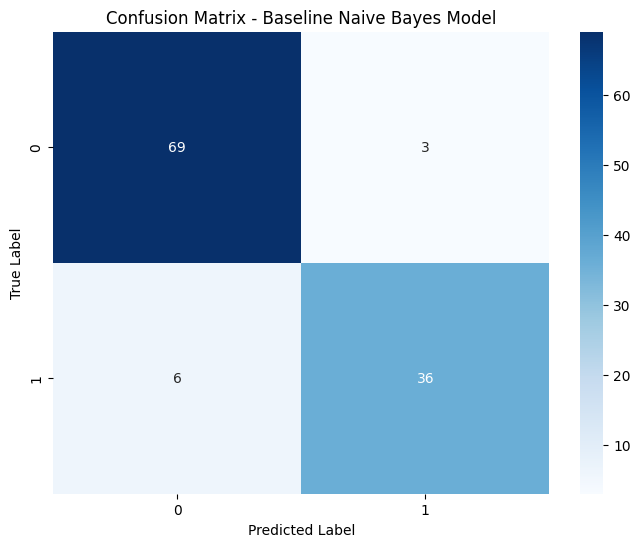

In [80]:
print("\n==== Experiment 1: Baseline Naive Bayes Model ====")
nb_baseline_model = GaussianNB()
nb_baseline_model.fit(X_train_scaled, y_train)

nb_y_pred_baseline = nb_baseline_model.predict(X_test_scaled)
nb_y_prob_baseline = nb_baseline_model.predict_proba(X_test_scaled)[:, 1]

nb_baseline_accuracy = accuracy_score(y_test, nb_y_pred_baseline)
nb_baseline_auc = roc_auc_score(y_test, nb_y_prob_baseline)

print(f"Accuracy: {nb_baseline_accuracy:.4f}")
print(f"ROC AUC: {nb_baseline_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, nb_y_pred_baseline))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, nb_y_pred_baseline)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Baseline Naive Bayes Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Dimensional Reduction


==== Experiment 2: PCA + Naive Bayes Model ====
Original features: 30
PCA features (95% variance): 10
Accuracy: 0.8947
ROC AUC: 0.9613

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        72
           1       0.86      0.86      0.86        42

    accuracy                           0.89       114
   macro avg       0.89      0.89      0.89       114
weighted avg       0.89      0.89      0.89       114



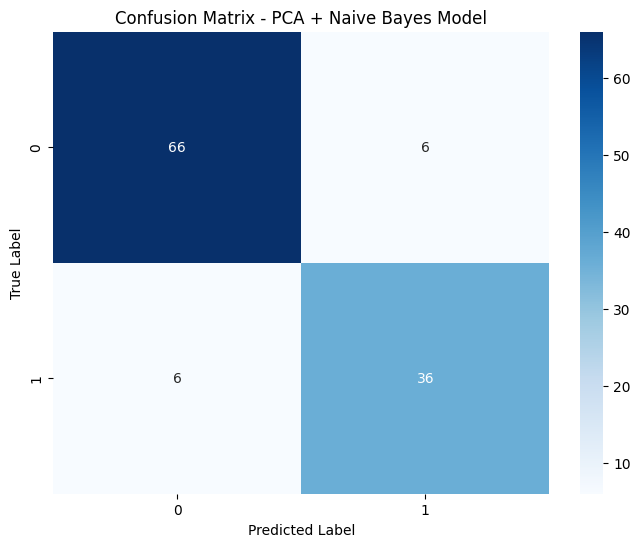

In [81]:
print("\n==== Experiment 2: PCA + Naive Bayes Model ====")

pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Original features: {X_train_scaled.shape[1]}")
print(f"PCA features (95% variance): {X_train_pca.shape[1]}")

nb_pca_model = GaussianNB()
nb_pca_model.fit(X_train_pca, y_train)

nb_y_pred_pca = nb_pca_model.predict(X_test_pca)
nb_y_prob_pca = nb_pca_model.predict_proba(X_test_pca)[:, 1]

nb_pca_accuracy = accuracy_score(y_test, nb_y_pred_pca)
nb_pca_auc = roc_auc_score(y_test, nb_y_prob_pca)

print(f"Accuracy: {nb_pca_accuracy:.4f}")
print(f"ROC AUC: {nb_pca_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, nb_y_pred_pca))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, nb_y_pred_pca)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - PCA + Naive Bayes Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Dimensionality Reduction and Regularization (var_smoothing)


==== Experiment 3: PCA + Optimized Naive Bayes Model ====
Best var_smoothing parameter: 1e-09
Accuracy: 0.8947
ROC AUC: 0.9613

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        72
           1       0.86      0.86      0.86        42

    accuracy                           0.89       114
   macro avg       0.89      0.89      0.89       114
weighted avg       0.89      0.89      0.89       114



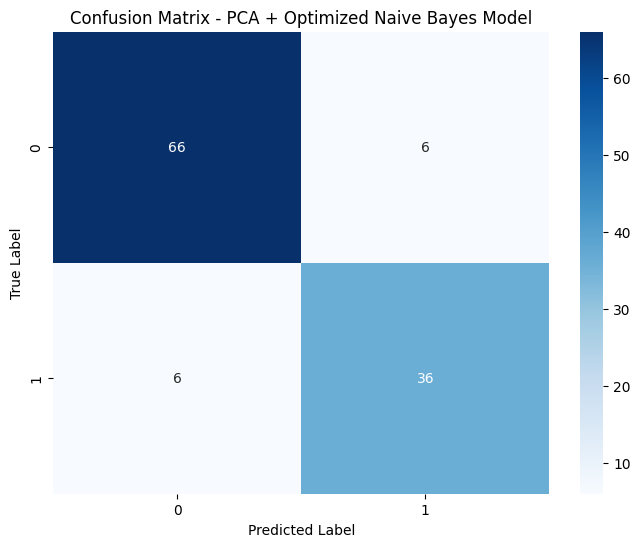

In [ ]:
print("\n==== Experiment 3: PCA + Optimized Naive Bayes Model ====")

nb_param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]}
nb_grid_search = GridSearchCV(
    GaussianNB(),
    nb_param_grid,
    cv=5,
    scoring='roc_auc'
)
nb_grid_search.fit(X_train_pca, y_train)

best_var_smoothing = nb_grid_search.best_params_['var_smoothing']
print(f"Best var_smoothing parameter: {best_var_smoothing}")

nb_pca_reg_model = GaussianNB(var_smoothing=best_var_smoothing)
nb_pca_reg_model.fit(X_train_pca, y_train)

nb_y_pred_pca_reg = nb_pca_reg_model.predict(X_test_pca)
nb_y_prob_pca_reg = nb_pca_reg_model.predict_proba(X_test_pca)[:, 1]

nb_pca_reg_accuracy = accuracy_score(y_test, nb_y_pred_pca_reg)
nb_pca_reg_auc = roc_auc_score(y_test, nb_y_prob_pca_reg)

print(f"Accuracy: {nb_pca_reg_accuracy:.4f}")
print(f"ROC AUC: {nb_pca_reg_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, nb_y_pred_pca_reg))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, nb_y_pred_pca_reg)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - PCA + Optimized Naive Bayes Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Compare


==== Model Comparison ====
                Model  Accuracy   ROC AUC  Features
0         Baseline NB  0.921053  0.989087        30
1            PCA + NB  0.894737  0.961310        10
2  PCA + Optimized NB  0.894737  0.961310        10


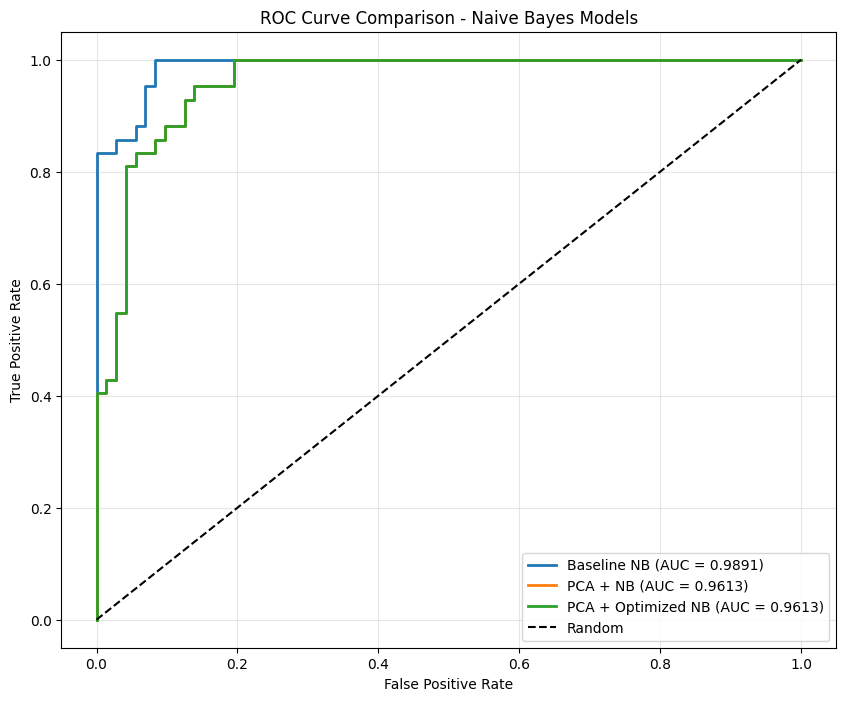

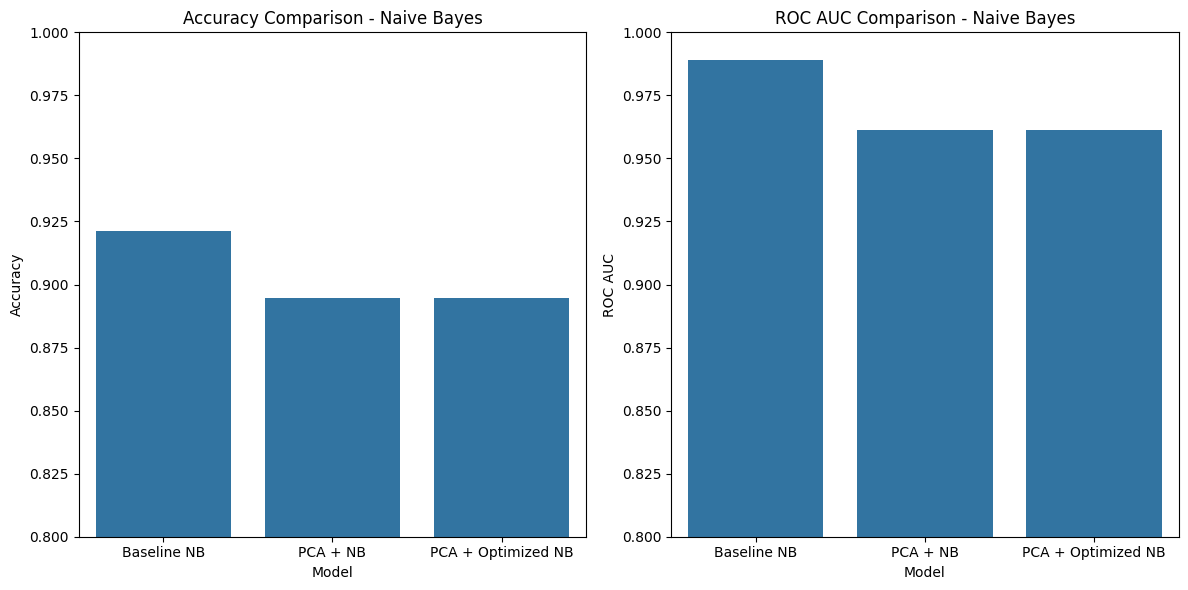

In [83]:
nb_results = pd.DataFrame({
    'Model': ['Baseline NB', 'PCA + NB', 'PCA + Optimized NB'],
    'Accuracy': [nb_baseline_accuracy, nb_pca_accuracy, nb_pca_reg_accuracy],
    'ROC AUC': [nb_baseline_auc, nb_pca_auc, nb_pca_reg_auc],
    'Features': [X_train_scaled.shape[1], X_train_pca.shape[1], X_train_pca.shape[1]]
})

print("\n==== Model Comparison ====")
print(nb_results)

plt.figure(figsize=(10, 8))

nb_fpr_base, nb_tpr_base, _ = roc_curve(y_test, nb_y_prob_baseline)
plt.plot(nb_fpr_base, nb_tpr_base, 
         label=f'Baseline NB (AUC = {nb_baseline_auc:.4f})', linewidth=2)

nb_fpr_pca, nb_tpr_pca, _ = roc_curve(y_test, nb_y_prob_pca)
plt.plot(nb_fpr_pca, nb_tpr_pca, 
         label=f'PCA + NB (AUC = {nb_pca_auc:.4f})', linewidth=2)

nb_fpr_pca_reg, nb_tpr_pca_reg, _ = roc_curve(y_test, nb_y_prob_pca_reg)
plt.plot(nb_fpr_pca_reg, nb_tpr_pca_reg, 
         label=f'PCA + Optimized NB (AUC = {nb_pca_reg_auc:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison - Naive Bayes Models')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='Accuracy', data=nb_results)
plt.title('Accuracy Comparison - Naive Bayes')
plt.ylim(0.8, 1.0)

plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='ROC AUC', data=nb_results)
plt.title('ROC AUC Comparison - Naive Bayes')
plt.ylim(0.8, 1.0) 

plt.tight_layout()
plt.show()

In [84]:
print("\n==== Conclusion - Naive Bayes ====")

nb_best_model_idx = nb_results['ROC AUC'].idxmax()
nb_best_model = nb_results.iloc[nb_best_model_idx]['Model']
print(f"Best performing NB model: {nb_best_model}")

nb_pca_effect = nb_pca_auc - nb_baseline_auc
print("\nEffect of dimensionality reduction:")
if nb_pca_effect > 0:
    print(f"- Improved performance by {nb_pca_effect:.4f} AUC while reducing features by "
          f"{X_train_scaled.shape[1] - X_train_pca.shape[1]} ({X_train_pca.shape[1]} vs {X_train_scaled.shape[1]})")
else:
    print(f"- Reduced performance by {-nb_pca_effect:.4f} AUC while reducing features by "
          f"{X_train_scaled.shape[1] - X_train_pca.shape[1]} ({X_train_pca.shape[1]} vs {X_train_scaled.shape[1]})")

nb_reg_effect = nb_pca_reg_auc - nb_pca_auc
print("\nEffect of var_smoothing optimization:")
if nb_reg_effect > 0:
    print(f"- Further improved performance by {nb_reg_effect:.4f} AUC")
    print(f"- Optimal var_smoothing: {best_var_smoothing}")
else:
    print(f"- Did not improve performance (difference: {nb_reg_effect:.4f} AUC)")
    print(f"- Selected var_smoothing: {best_var_smoothing}")


==== Conclusion - Naive Bayes ====
Best performing NB model: Baseline NB

Effect of dimensionality reduction:
- Reduced performance by 0.0278 AUC while reducing features by 20 (10 vs 30)

Effect of var_smoothing optimization:
- Did not improve performance (difference: 0.0000 AUC)
- Selected var_smoothing: 1e-09


# SVM

## Baseline


==== Experiment 1: Baseline SVM Model ====
Accuracy: 0.9737
ROC AUC: 0.9947

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



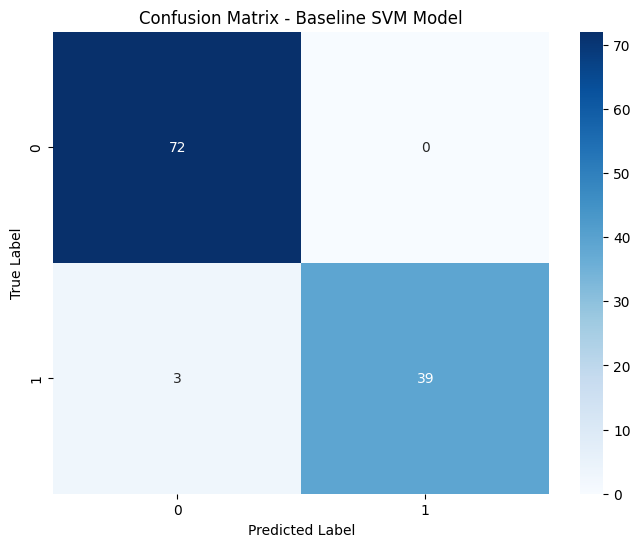

In [85]:
print("\n==== Experiment 1: Baseline SVM Model ====")
svm_baseline_model = SVC(probability=True, random_state=42)  
svm_baseline_model.fit(X_train_scaled, y_train)

svm_y_pred_baseline = svm_baseline_model.predict(X_test_scaled)
svm_y_prob_baseline = svm_baseline_model.predict_proba(X_test_scaled)[:, 1]

svm_baseline_accuracy = accuracy_score(y_test, svm_y_pred_baseline)
svm_baseline_auc = roc_auc_score(y_test, svm_y_prob_baseline)

print(f"Accuracy: {svm_baseline_accuracy:.4f}")
print(f"ROC AUC: {svm_baseline_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, svm_y_pred_baseline))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, svm_y_pred_baseline)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Baseline SVM Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Dimensional Reduction


==== Experiment 2: PCA + SVM Model ====
Original features: 30
PCA features (95% variance): 10
Accuracy: 0.9649
ROC AUC: 0.9954

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        72
           1       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114



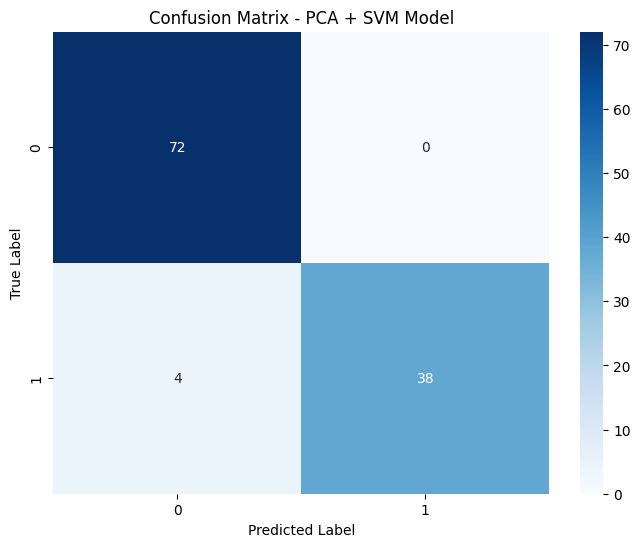

In [86]:
print("\n==== Experiment 2: PCA + SVM Model ====")

print(f"Original features: {X_train_scaled.shape[1]}")
print(f"PCA features (95% variance): {X_train_pca.shape[1]}")

svm_pca_model = SVC(probability=True, random_state=42)
svm_pca_model.fit(X_train_pca, y_train)

svm_y_pred_pca = svm_pca_model.predict(X_test_pca)
svm_y_prob_pca = svm_pca_model.predict_proba(X_test_pca)[:, 1]

svm_pca_accuracy = accuracy_score(y_test, svm_y_pred_pca)
svm_pca_auc = roc_auc_score(y_test, svm_y_prob_pca)

print(f"Accuracy: {svm_pca_accuracy:.4f}")
print(f"ROC AUC: {svm_pca_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, svm_y_pred_pca))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, svm_y_pred_pca)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - PCA + SVM Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Dimensional Reduction + Regularization


==== Experiment 3: PCA + Regularized SVM Model ====
Best SVM parameters: {'C': 1, 'gamma': 'scale'}
Accuracy: 0.9649
ROC AUC: 0.9954

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        72
           1       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114



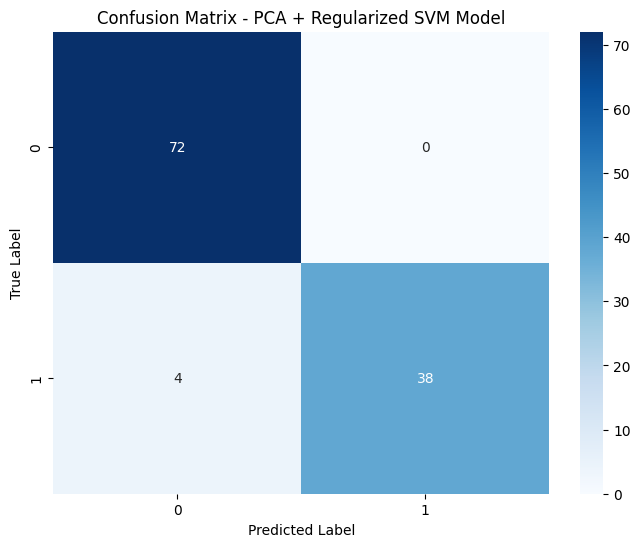

In [87]:
print("\n==== Experiment 3: PCA + Regularized SVM Model ====")

svm_param_grid = {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto', 0.1, 0.01]}
svm_grid_search = GridSearchCV(
    SVC(probability=True, random_state=42),
    svm_param_grid,
    cv=5,
    scoring='roc_auc'
)
svm_grid_search.fit(X_train_pca, y_train)

svm_best_params = svm_grid_search.best_params_
print(f"Best SVM parameters: {svm_best_params}")

svm_pca_reg_model = SVC(probability=True, random_state=42, **svm_best_params)
svm_pca_reg_model.fit(X_train_pca, y_train)

svm_y_pred_pca_reg = svm_pca_reg_model.predict(X_test_pca)
svm_y_prob_pca_reg = svm_pca_reg_model.predict_proba(X_test_pca)[:, 1]

svm_pca_reg_accuracy = accuracy_score(y_test, svm_y_pred_pca_reg)
svm_pca_reg_auc = roc_auc_score(y_test, svm_y_prob_pca_reg)

print(f"Accuracy: {svm_pca_reg_accuracy:.4f}")
print(f"ROC AUC: {svm_pca_reg_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, svm_y_pred_pca_reg))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, svm_y_pred_pca_reg)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - PCA + Regularized SVM Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Compare


==== SVM Model Comparison ====
                   Model  Accuracy   ROC AUC  Features
0           Baseline SVM  0.973684  0.994709        30
1              PCA + SVM  0.964912  0.995370        10
2  PCA + Regularized SVM  0.964912  0.995370        10


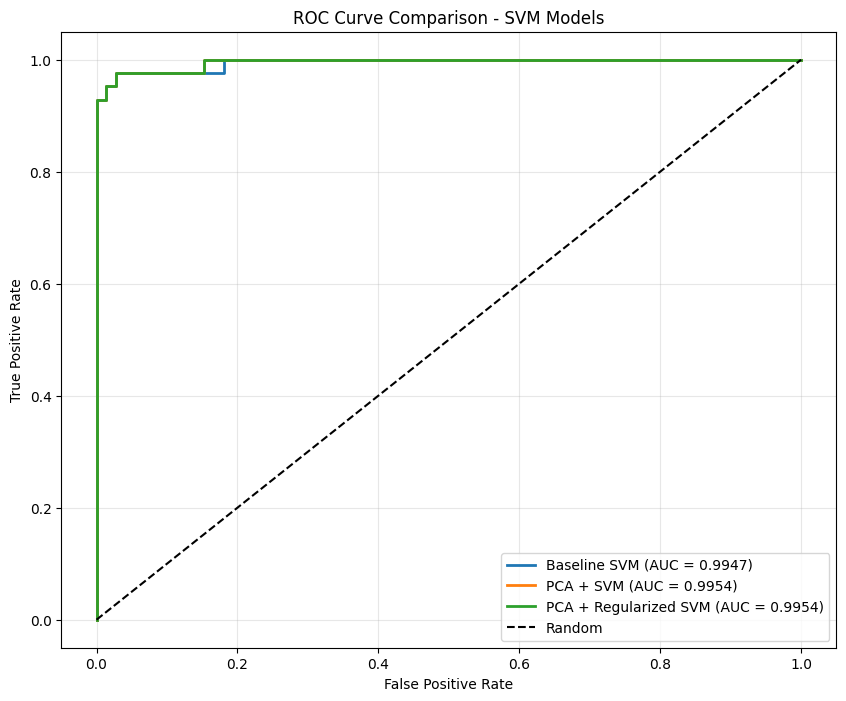

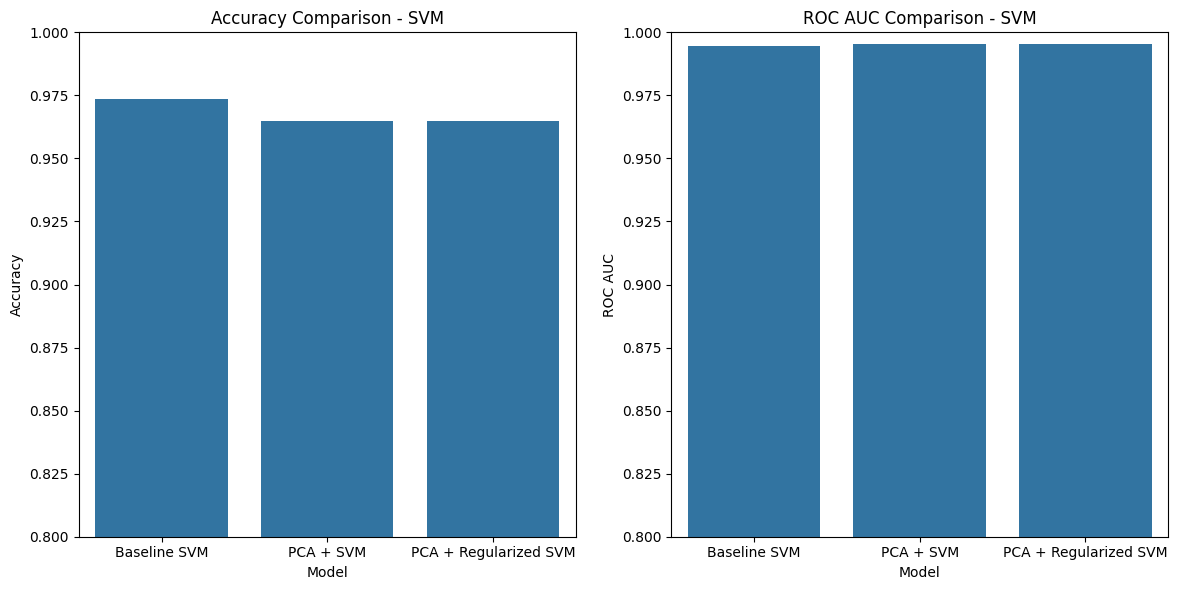

In [88]:
svm_results = pd.DataFrame({
    'Model': ['Baseline SVM', 'PCA + SVM', 'PCA + Regularized SVM'],
    'Accuracy': [svm_baseline_accuracy, svm_pca_accuracy, svm_pca_reg_accuracy],
    'ROC AUC': [svm_baseline_auc, svm_pca_auc, svm_pca_reg_auc],
    'Features': [X_train_scaled.shape[1], X_train_pca.shape[1], X_train_pca.shape[1]]
})

print("\n==== SVM Model Comparison ====")
print(svm_results)

plt.figure(figsize=(10, 8))

svm_fpr_base, svm_tpr_base, _ = roc_curve(y_test, svm_y_prob_baseline)
plt.plot(svm_fpr_base, svm_tpr_base, 
         label=f'Baseline SVM (AUC = {svm_baseline_auc:.4f})', linewidth=2)

svm_fpr_pca, svm_tpr_pca, _ = roc_curve(y_test, svm_y_prob_pca)
plt.plot(svm_fpr_pca, svm_tpr_pca, 
         label=f'PCA + SVM (AUC = {svm_pca_auc:.4f})', linewidth=2)

svm_fpr_pca_reg, svm_tpr_pca_reg, _ = roc_curve(y_test, svm_y_prob_pca_reg)
plt.plot(svm_fpr_pca_reg, svm_tpr_pca_reg, 
         label=f'PCA + Regularized SVM (AUC = {svm_pca_reg_auc:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison - SVM Models')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='Accuracy', data=svm_results)
plt.title('Accuracy Comparison - SVM')
plt.ylim(0.8, 1.0)

plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='ROC AUC', data=svm_results)
plt.title('ROC AUC Comparison - SVM')
plt.ylim(0.8, 1.0)

plt.tight_layout()
plt.show()

## Conclusion

In [89]:
print("\n==== Conclusion - SVM ====")

svm_best_model_idx = svm_results['ROC AUC'].idxmax()
svm_best_model = svm_results.iloc[svm_best_model_idx]['Model']
print(f"Best performing SVM model: {svm_best_model}")

svm_pca_effect = svm_pca_auc - svm_baseline_auc
print("\nEffect of dimensionality reduction:")
if svm_pca_effect > 0:
    print(f"- Improved performance by {svm_pca_effect:.4f} AUC while reducing features by "
          f"{X_train_scaled.shape[1] - X_train_pca.shape[1]} ({X_train_pca.shape[1]} vs {X_train_scaled.shape[1]})")
else:
    print(f"- Reduced performance by {-svm_pca_effect:.4f} AUC while reducing features by "
          f"{X_train_scaled.shape[1] - X_train_pca.shape[1]} ({X_train_pca.shape[1]} vs {X_train_scaled.shape[1]})")

svm_reg_effect = svm_pca_reg_auc - svm_pca_auc
print("\nEffect of SVM parameter optimization:")
if svm_reg_effect > 0:
    print(f"- Further improved performance by {svm_reg_effect:.4f} AUC")
    print(f"- Optimal parameters: C={svm_best_params['C']}, gamma={svm_best_params['gamma']}")
else:
    print(f"- Did not improve performance (difference: {svm_reg_effect:.4f} AUC)")
    print(f"- Selected parameters: C={svm_best_params['C']}, gamma={svm_best_params['gamma']}")


==== Conclusion - SVM ====
Best performing SVM model: PCA + SVM

Effect of dimensionality reduction:
- Improved performance by 0.0007 AUC while reducing features by 20 (10 vs 30)

Effect of SVM parameter optimization:
- Did not improve performance (difference: 0.0000 AUC)
- Selected parameters: C=1, gamma=scale


# KNN

## Baseline


==== Experiment 1: Baseline KNN Model ====
Accuracy: 0.9561
ROC AUC: 0.9823

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97        72
           1       0.97      0.90      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



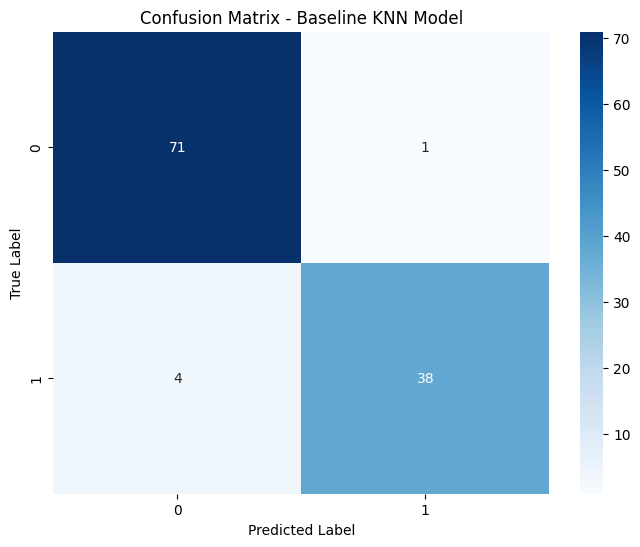

In [90]:
print("\n==== Experiment 1: Baseline KNN Model ====")
knn_baseline_model = KNeighborsClassifier(n_neighbors=5) 
knn_baseline_model.fit(X_train_scaled, y_train)

knn_y_pred_baseline = knn_baseline_model.predict(X_test_scaled)
knn_y_prob_baseline = knn_baseline_model.predict_proba(X_test_scaled)[:, 1]

knn_baseline_accuracy = accuracy_score(y_test, knn_y_pred_baseline)
knn_baseline_auc = roc_auc_score(y_test, knn_y_prob_baseline)

print(f"Accuracy: {knn_baseline_accuracy:.4f}")
print(f"ROC AUC: {knn_baseline_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, knn_y_pred_baseline))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, knn_y_pred_baseline)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Baseline KNN Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Dimensionality Reduction


==== Experiment 2: PCA + KNN Model ====
Original features: 30
PCA features (95% variance): 10
Accuracy: 0.9561
ROC AUC: 0.9838

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97        72
           1       0.97      0.90      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



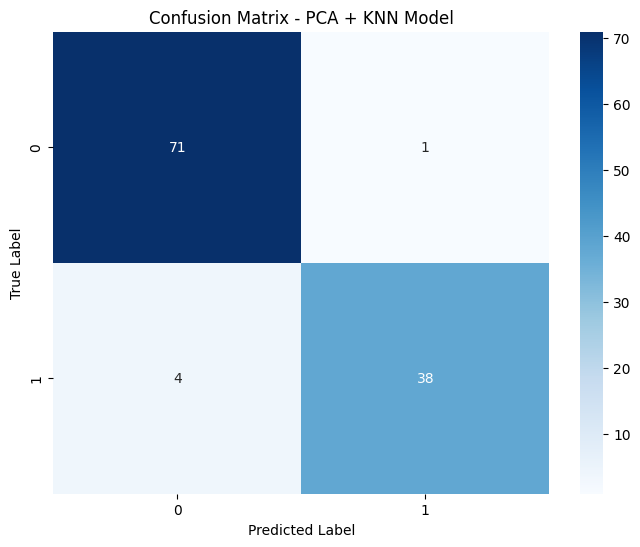

In [91]:

print("\n==== Experiment 2: PCA + KNN Model ====")

print(f"Original features: {X_train_scaled.shape[1]}")
print(f"PCA features (95% variance): {X_train_pca.shape[1]}")

knn_pca_model = KNeighborsClassifier(n_neighbors=5)
knn_pca_model.fit(X_train_pca, y_train)

knn_y_pred_pca = knn_pca_model.predict(X_test_pca)
knn_y_prob_pca = knn_pca_model.predict_proba(X_test_pca)[:, 1]

knn_pca_accuracy = accuracy_score(y_test, knn_y_pred_pca)
knn_pca_auc = roc_auc_score(y_test, knn_y_prob_pca)

print(f"Accuracy: {knn_pca_accuracy:.4f}")
print(f"ROC AUC: {knn_pca_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, knn_y_pred_pca))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, knn_y_pred_pca)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - PCA + KNN Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Dimensionality Reduction + Regularization (Hyperparameter Tuning)


==== Experiment 3: PCA + Optimized KNN Model ====
Best KNN parameters: {'n_neighbors': 11, 'p': 1, 'weights': 'distance'}
Accuracy: 0.9649
ROC AUC: 0.9825

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        72
           1       0.97      0.93      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



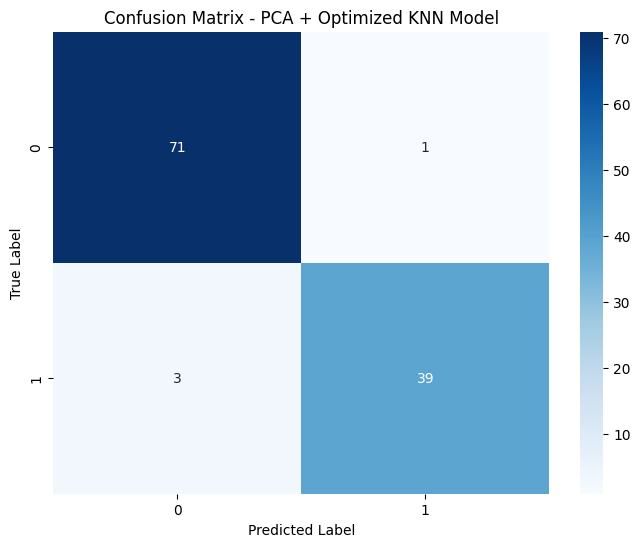

In [92]:
print("\n==== Experiment 3: PCA + Optimized KNN Model ====")

knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2] 
}
knn_grid_search = GridSearchCV(
    KNeighborsClassifier(),
    knn_param_grid,
    cv=5,
    scoring='roc_auc'
)
knn_grid_search.fit(X_train_pca, y_train)

knn_best_params = knn_grid_search.best_params_
print(f"Best KNN parameters: {knn_best_params}")

knn_pca_opt_model = KNeighborsClassifier(**knn_best_params)
knn_pca_opt_model.fit(X_train_pca, y_train)

knn_y_pred_pca_opt = knn_pca_opt_model.predict(X_test_pca)
knn_y_prob_pca_opt = knn_pca_opt_model.predict_proba(X_test_pca)[:, 1]

knn_pca_opt_accuracy = accuracy_score(y_test, knn_y_pred_pca_opt)
knn_pca_opt_auc = roc_auc_score(y_test, knn_y_prob_pca_opt)

print(f"Accuracy: {knn_pca_opt_accuracy:.4f}")
print(f"ROC AUC: {knn_pca_opt_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, knn_y_pred_pca_opt))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, knn_y_pred_pca_opt)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - PCA + Optimized KNN Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Compare


==== KNN Model Comparison ====
                 Model  Accuracy   ROC AUC  Features
0         Baseline KNN  0.956140  0.982308        30
1            PCA + KNN  0.956140  0.983796        10
2  PCA + Optimized KNN  0.964912  0.982474        10


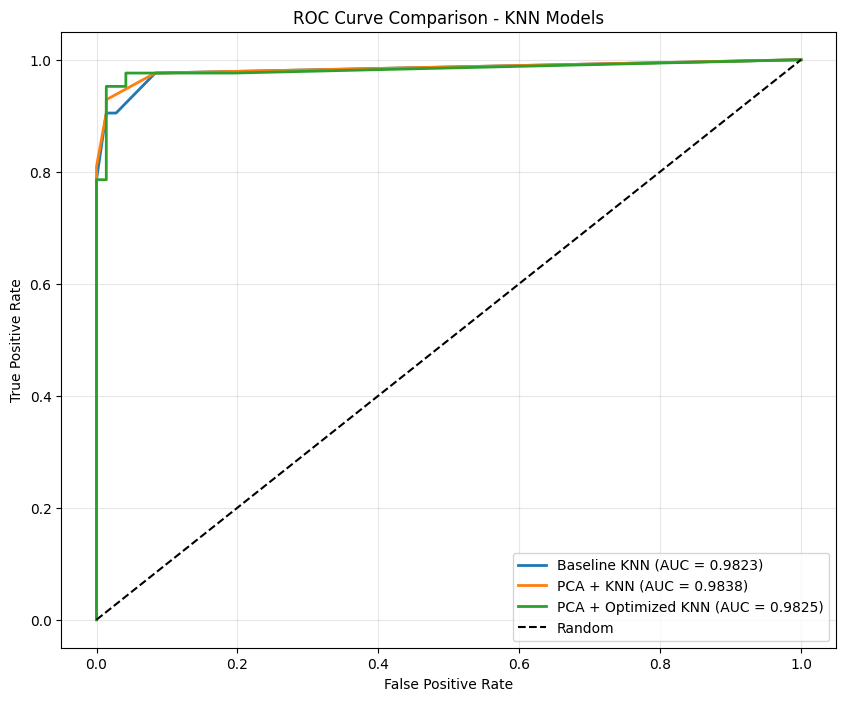

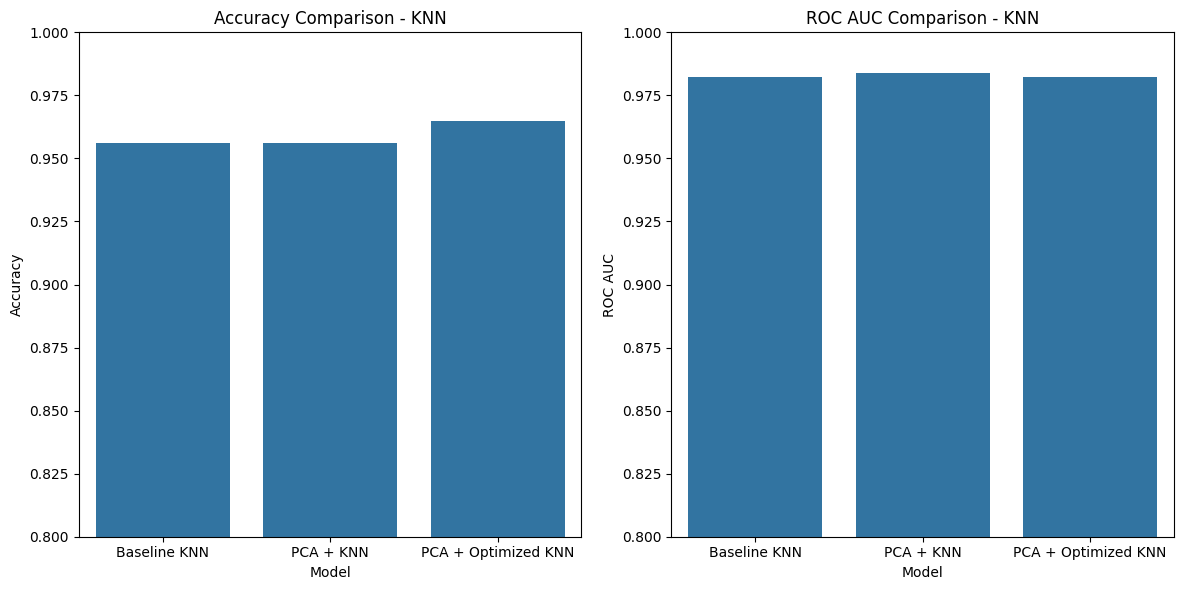

In [93]:
knn_results = pd.DataFrame({
    'Model': ['Baseline KNN', 'PCA + KNN', 'PCA + Optimized KNN'],
    'Accuracy': [knn_baseline_accuracy, knn_pca_accuracy, knn_pca_opt_accuracy],
    'ROC AUC': [knn_baseline_auc, knn_pca_auc, knn_pca_opt_auc],
    'Features': [X_train_scaled.shape[1], X_train_pca.shape[1], X_train_pca.shape[1]]
})

print("\n==== KNN Model Comparison ====")
print(knn_results)

plt.figure(figsize=(10, 8))

knn_fpr_base, knn_tpr_base, _ = roc_curve(y_test, knn_y_prob_baseline)
plt.plot(knn_fpr_base, knn_tpr_base, 
         label=f'Baseline KNN (AUC = {knn_baseline_auc:.4f})', linewidth=2)

knn_fpr_pca, knn_tpr_pca, _ = roc_curve(y_test, knn_y_prob_pca)
plt.plot(knn_fpr_pca, knn_tpr_pca, 
         label=f'PCA + KNN (AUC = {knn_pca_auc:.4f})', linewidth=2)

knn_fpr_pca_opt, knn_tpr_pca_opt, _ = roc_curve(y_test, knn_y_prob_pca_opt)
plt.plot(knn_fpr_pca_opt, knn_tpr_pca_opt, 
         label=f'PCA + Optimized KNN (AUC = {knn_pca_opt_auc:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison - KNN Models')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='Accuracy', data=knn_results)
plt.title('Accuracy Comparison - KNN')
plt.ylim(0.8, 1.0)

plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='ROC AUC', data=knn_results)
plt.title('ROC AUC Comparison - KNN')
plt.ylim(0.8, 1.0) 

plt.tight_layout()
plt.show()

## Conclusion

In [94]:
print("\n==== Conclusion - KNN ====")

knn_best_model_idx = knn_results['ROC AUC'].idxmax()
knn_best_model = knn_results.iloc[knn_best_model_idx]['Model']
print(f"Best performing KNN model: {knn_best_model}")

knn_pca_effect = knn_pca_auc - knn_baseline_auc
print("\nEffect of dimensionality reduction:")
if knn_pca_effect > 0:
    print(f"- Improved performance by {knn_pca_effect:.4f} AUC while reducing features by "
          f"{X_train_scaled.shape[1] - X_train_pca.shape[1]} ({X_train_pca.shape[1]} vs {X_train_scaled.shape[1]})")
else:
    print(f"- Reduced performance by {-knn_pca_effect:.4f} AUC while reducing features by "
          f"{X_train_scaled.shape[1] - X_train_pca.shape[1]} ({X_train_pca.shape[1]} vs {X_train_scaled.shape[1]})")

knn_opt_effect = knn_pca_opt_auc - knn_pca_auc
print("\nEffect of KNN hyperparameter optimization:")
if knn_opt_effect > 0:
    print(f"- Further improved performance by {knn_opt_effect:.4f} AUC")
    print(f"- Optimal parameters: n_neighbors={knn_best_params['n_neighbors']}, "
          f"weights={knn_best_params['weights']}, metric=Minkowski p={knn_best_params['p']}")
else:
    print(f"- Did not improve performance (difference: {knn_opt_effect:.4f} AUC)")
    print(f"- Selected parameters: n_neighbors={knn_best_params['n_neighbors']}, "
          f"weights={knn_best_params['weights']}, metric=Minkowski p={knn_best_params['p']}")


==== Conclusion - KNN ====
Best performing KNN model: PCA + KNN

Effect of dimensionality reduction:
- Improved performance by 0.0015 AUC while reducing features by 20 (10 vs 30)

Effect of KNN hyperparameter optimization:
- Did not improve performance (difference: -0.0013 AUC)
- Selected parameters: n_neighbors=11, weights=distance, metric=Minkowski p=1



==== Comprehensive Model Comparison ====
            Model            Algorithm    Variant  Accuracy   ROC AUC
0    PCA + Reg LR  Logistic Regression  PCA + Reg  0.982456  0.998016
1          PCA LR  Logistic Regression        PCA  0.973684  0.997024
2     Baseline LR  Logistic Regression   Baseline  0.964912  0.996032
3         PCA SVM                  SVM        PCA  0.964912  0.995370
4   PCA + Opt SVM                  SVM  PCA + Opt  0.964912  0.995370
5    Baseline SVM                  SVM   Baseline  0.973684  0.994709
6     Baseline NB          Naive Bayes   Baseline  0.921053  0.989087
7         PCA KNN                  KNN        PCA  0.956140  0.983796
8   PCA + Opt KNN                  KNN  PCA + Opt  0.964912  0.982474
9    Baseline KNN                  KNN   Baseline  0.956140  0.982308
10         PCA NB          Naive Bayes        PCA  0.894737  0.961310
11   PCA + Opt NB          Naive Bayes  PCA + Opt  0.894737  0.961310

Best Overall Model: PCA + Reg LR with ROC AUC o

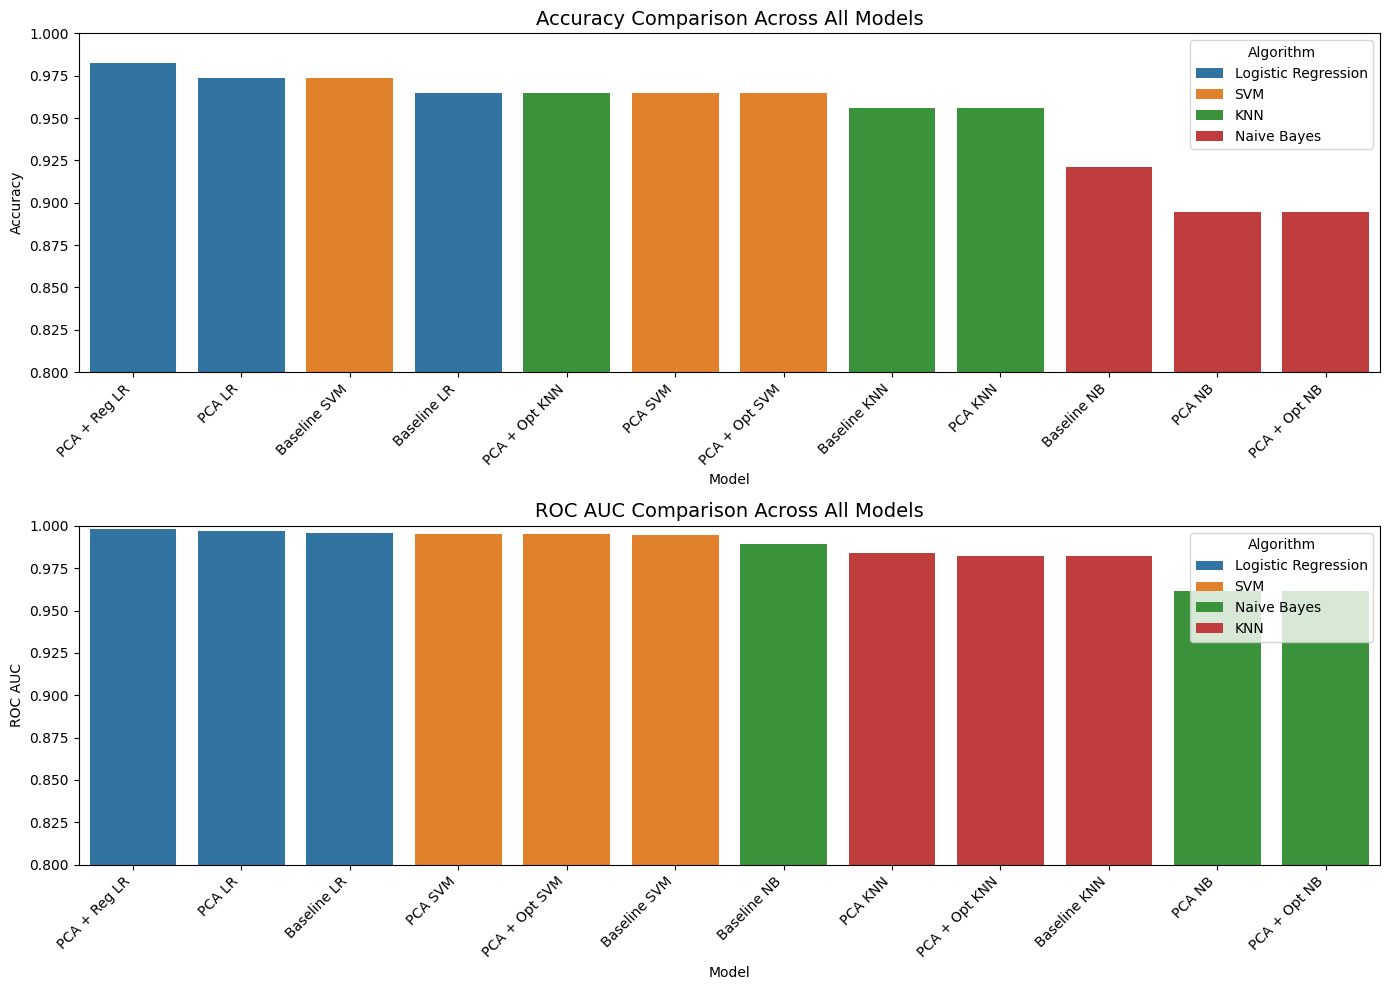

In [95]:
all_models_results = pd.DataFrame({
    'Model': [
        'Baseline LR', 'PCA LR', 'PCA + Reg LR',
        'Baseline NB', 'PCA NB', 'PCA + Opt NB',
        'Baseline SVM', 'PCA SVM', 'PCA + Opt SVM',
        'Baseline KNN', 'PCA KNN', 'PCA + Opt KNN'
    ],
    'Algorithm': [
        'Logistic Regression', 'Logistic Regression', 'Logistic Regression',
        'Naive Bayes', 'Naive Bayes', 'Naive Bayes',
        'SVM', 'SVM', 'SVM',
        'KNN', 'KNN', 'KNN'
    ],
    'Variant': [
        'Baseline', 'PCA', 'PCA + Reg',
        'Baseline', 'PCA', 'PCA + Opt',
        'Baseline', 'PCA', 'PCA + Opt',
        'Baseline', 'PCA', 'PCA + Opt'
    ],
    'Accuracy': [
        baseline_accuracy, pca_accuracy, pca_reg_accuracy,
        nb_baseline_accuracy, nb_pca_accuracy, nb_pca_reg_accuracy,
        svm_baseline_accuracy, svm_pca_accuracy, svm_pca_reg_accuracy,
        knn_baseline_accuracy, knn_pca_accuracy, knn_pca_opt_accuracy
    ],
    'ROC AUC': [
        baseline_auc, pca_auc, pca_reg_auc,
        nb_baseline_auc, nb_pca_auc, nb_pca_reg_auc,
        svm_baseline_auc, svm_pca_auc, svm_pca_reg_auc,
        knn_baseline_auc, knn_pca_auc, knn_pca_opt_auc
    ]
})

all_models_results_sorted = all_models_results.sort_values(by='ROC AUC', ascending=False).reset_index(drop=True)

print("\n==== Comprehensive Model Comparison ====")
print(all_models_results_sorted)

best_model = all_models_results_sorted.iloc[0]
print(f"\nBest Overall Model: {best_model['Model']} with ROC AUC of {best_model['ROC AUC']:.4f} and Accuracy of {best_model['Accuracy']:.4f}")

plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)

accuracy_sorted = all_models_results.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
sns.barplot(x='Model', y='Accuracy', data=accuracy_sorted, hue='Algorithm', dodge=False)
plt.title('Accuracy Comparison Across All Models', fontsize=14)
plt.ylim(0.8, 1.0)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Algorithm')

plt.subplot(2, 1, 2)

sns.barplot(x='Model', y='ROC AUC', data=all_models_results_sorted, hue='Algorithm', dodge=False)
plt.title('ROC AUC Comparison Across All Models', fontsize=14)
plt.ylim(0.8, 1.0) 
plt.xticks(rotation=45, ha='right')
plt.legend(title='Algorithm')

plt.tight_layout()
plt.show()